Hello,
I am A Sai Manoj, student at National Institute of Technology, Calicut.<br/>
In this kernel, I am going to train a RNN for time series prediction(part 2 in the given task) in a self supervised way!<br/>
We know that every data has some flaws and this data is not an exception. The data has some missing values in it. We can deal with the missing values by directly dropping them or filling them with some constant. But both these methods have their own disadvantages.<br/>
First one will effect the size of training data and in the later one, we are imposing a high error in missing values which might effect our model's performace.<br/>
So I came up with a **self supervised way of training** which makes model to get an overview of data.

## My Idea:
1. Building a dynamic RNN with dense layers on top of it.
2. Now, this model takes sequence of length 5 of which we randomly make some elements zero(I have made 1 or 2 elements zero randomly) and a mask having 1's at the positions where we made zeros in the sequence and 0's at rest of the positions as inputs and output the a sequence of same length 5
3. we will optimize the above built RNN to output a sequence of same length 5, having missing values.This concludes our pretraining part which is purely inspired from masked language modelling from field of Natural Language Processing.
4. Now, we will take the pretrained model and remove the dense layers(which are on top of RNN) and retrain this model to predict put calls ratio on august 15th from the data of august 10th,11th,12th,14th.
5. That's it! we are done with building a time series model which can predict put calls ratio by considering the values of prior 5 days.
 
Feel free to go through the below code to get to know about the additional information like hyperparemeters, architecture, etc.,.


In [ ]:
from google.colab import drive
#mounting my google drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
!pip install tensorflow==2.0

In [ ]:
#importing required libraries
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv1D, Input, Bidirectional, LSTM, RNN, Dense, Concatenate
from tensorflow.keras import backend as K
import random
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import Sequence
from tensorflow.keras.models import load_model

#Pretraining Phase

In [ ]:
#directories
test_dir = '/content/gdrive/My Drive/hackathon/Test_dataset.xlsx'
#loading data
test_data =pd.read_excel(test_dir,'Put-Call_TS')
#changing names
test_data=test_data.rename(columns={'Put-Call Ratio':'aug10','Unnamed: 2':'aug11','Unnamed: 3':'aug12','Unnamed: 4':'aug13','Unnamed: 5':'aug14','Unnamed: 6':'aug15'})
#dropping first row(which is nothing but date and time)
test_data=test_data.drop([0],axis=0)
#show top 5 rows of training dataframe
test_data.head()

,Stock Index,aug10,aug11,aug12,aug13,aug14,aug15
1,AC3235,0.8,0.66,0.7724,0.983224,0.901211,0.898368
2,AC3236,0.86,0.732,0.85448,1.08664,1.01704,1.02926
3,AC3237,0.93,0.816,0.95024,1.2073,NaN,1.18196
4,AC3238,1.09,1.008,1.16912,1.48309,1.46106,1.531
5,AC3239,NaN,1.104,1.27856,1.62099,1.6155,1.70552


In [ ]:
#no of missing values in dataset
print('no of missing values:')
print(test_data.isna().sum())

no of missing values:
Stock Index      0
aug10          429
aug11            2
aug12           57
aug13           14
aug14          105
aug15          239
dtype: int64


In [ ]:
#dropping the missing data in pretraining phase(later we will retrieve it and use the whole data in fine tuning the model)
test_data = test_data.dropna()

In [ ]:
test_data.head()

,Stock Index,aug10,aug11,aug12,aug13,aug14,aug15
1,AC3235,0.8,0.66,0.7724,0.983224,0.901211,0.898368
2,AC3236,0.86,0.732,0.85448,1.08664,1.01704,1.02926
4,AC3238,1.09,1.008,1.16912,1.48309,1.46106,1.531
7,AC3241,1.23,1.176,1.36064,1.72441,1.73134,1.83641
8,AC3242,1,0.9,1.046,1.32796,1.28732,1.33467


In [ ]:
#build model
def build_model(MAX_LEN):
    inputs = Input((None,2))
    x = Bidirectional(LSTM(64,return_sequences=True))(inputs)
    x = Bidirectional(LSTM(64))(x)
    x = Dense(MAX_LEN,activation='relu')(x)
    x_reshape = tf.expand_dims(x,axis = -1)
    zeros = tf.zeros_like(x_reshape)
    x_pad = Concatenate(axis=-1)([x_reshape,zeros])
    model = Model(inputs,x_pad)
    final_model = Model(inputs,x)
    return model
model = build_model(5)
model.summary()
#loss
def regloss(y_true,y_pred):
    mask = y_true[...,1]
    y_true = y_true[...,0]
    y_pred = y_pred[...,0]
    loss = K.sum(((y_true-y_pred)**2)*mask,axis=-1)
    return loss

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, 2)]    0                                            
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, None, 128)    34304       input_1[0][0]                    
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 128)          98816       bidirectional[0][0]              
__________________________________________________________________________________________________
dense (Dense)                   (None, 5)            645         bidirectional_1[0][0]            
______________________________________________________________________________________________

In [ ]:
#preparing data
X = []
Y = []
for i in range(test_data.shape[0]):
    #considering 5 at a time
    x = test_data.iloc[i,1:6].values.astype('float32')
    x_ = test_data.iloc[i,2:7].values.astype('float32')
    mask = np.zeros((5,1))
    mask_ = np.zeros((5,1))
    nums = random.choice([1,2])
    nums_ = random.choice([1,2])
    indicies = random.choices([0,1,2,3,4],k=nums)
    indicies_ = random.choices([0,1,2,3,4],k=nums_)
    mask[indicies] = 1
    mask[indicies_] = 1
    y_true = np.concatenate((np.expand_dims(x,axis = -1),mask),axis=-1)
    x1 = x*(1-mask.reshape(-1))
    y_true_ = np.concatenate((np.expand_dims(x_,axis = -1),mask_),axis=-1)
    x1_ = x*(1-mask.reshape(-1))
    input = np.concatenate((np.expand_dims(x1,axis = -1),mask),axis=-1)
    input_ = np.concatenate((np.expand_dims(x1_,axis = -1),mask_),axis=-1)
    X.append(input)
    X.append(input_)
    Y.append(y_true)
    Y.append(y_true_)
X = np.asarray(X)
Y = np.asarray(Y)

In [ ]:
#splitting
valid_data = (X[:150],Y[:150])
model = build_model(5)
#optimizer 
optimizer = Adam(lr=0.0001)
#compile model
model.compile(loss=regloss,optimizer=optimizer)
#self supervised training
history = model.fit(X[150:],Y[150:],batch_size=32,verbose=1,epochs=200,validation_data=valid_data)

Train on 5280 samples, validate on 150 samples
Epoch 1/200
5280/5280 [==============================] - 10s 2ms/sample - loss: 0.7882 - val_loss: 0.4375
Epoch 2/200
5280/5280 [==============================] - 3s 491us/sample - loss: 0.4206 - val_loss: 0.4344
Epoch 3/200
5280/5280 [==============================] - 3s 496us/sample - loss: 0.4166 - val_loss: 0.4326
Epoch 4/200
5280/5280 [==============================] - 3s 493us/sample - loss: 0.4138 - val_loss: 0.4295
Epoch 5/200
5280/5280 [==============================] - 3s 498us/sample - loss: 0.4109 - val_loss: 0.4244
Epoch 6/200
5280/5280 [==============================] - 3s 494us/sample - loss: 0.4081 - val_loss: 0.4206
Epoch 7/200
5280/5280 [==============================] - 3s 488us/sample - loss: 0.4058 - val_loss: 0.4192
Epoch 8/200
5280/5280 [==============================] - 3s 506us/sample - loss: 0.4038 - val_loss: 0.4162
Epoch 9/200
5280/5280 [==============================] - 3s 496us/sample - loss: 0.4019 - val_loss

In [ ]:
#saving weights
model.save('/content/gdrive/My Drive/hackathon/lstm.h5')

# Finetuning Phase


In [ ]:
def regloss(y_true,y_pred):
    mask = y_true[...,1]
    y_true = y_true[...,0]
    y_pred = y_pred[...,0]
    loss = K.sum(((y_true-y_pred)**2)*mask,axis=-1)
    return loss
#model for finetuning(remove top dense layer and add a dense layer of one node)
def build_final_model(filename):
    model = load_model(filename,custom_objects={'regloss':regloss})
    dense1 = Dense(32,activation='relu',kernel_initializer='glorot_uniform')(model.layers[-5].output)
    dense2 = Dense(1,activation='relu',kernel_initializer='glorot_uniform')(dense1)
    model = Model(model.input,dense2)
    return model
model = build_final_model('/content/gdrive/My Drive/hackathon/lstm.h5')
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, None, 2)]         0         
_________________________________________________________________
bidirectional_6 (Bidirection (None, None, 128)         34304     
_________________________________________________________________
bidirectional_7 (Bidirection (None, 128)               98816     
_________________________________________________________________
dense_6 (Dense)              (None, 32)                4128      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 33        
Total params: 137,281
Trainable params: 137,281
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#directories
test_dir = '/content/gdrive/My Drive/hackathon/Test_dataset.xlsx'
#loading data
test_data =pd.read_excel(test_dir,'Put-Call_TS')
#changing names
test_data=test_data.rename(columns={'Put-Call Ratio':'aug10','Unnamed: 2':'aug11','Unnamed: 3':'aug12','Unnamed: 4':'aug13','Unnamed: 5':'aug14','Unnamed: 6':'aug15'})
#dropping first row(which is nothing but date and time)
test_data=test_data.drop([0],axis=0)
#show top 5 rows of training dataframe
test_data.head()
test_data.fillna(0,inplace=True)

In [ ]:
#arrays of (5,2) for timeseries prediction
X = []
Y = []
for i in range(test_data.shape[0]):
    #considering 5 at a time
    x = test_data.iloc[i,1:6].values.astype('float32')
    indicies = np.where(x==0)
    mask = np.zeros((5,1))
    mask[indicies]=1
    x = np.concatenate((np.expand_dims(x,axis = -1),mask),axis=-1)
    if test_data.iloc[i,6]!=0:
        X.append(x)
        Y.append(test_data.iloc[i,6].astype('float32'))
X = np.asarray(X)
Y = np.asarray(Y)

In [ ]:
print(X.shape,
Y.shape)

(3092, 5, 2) (3092,)


In [ ]:
#splitting
X_val = X[:200]
Y_val = Y[:200]
X_train = X[200:]
Y_train = Y[200:]
#building model
model = build_final_model('/content/gdrive/My Drive/hackathon/lstm.h5')
for layer in model.layers:
    layer.trainable = True
#callbacks
mcp_save = ModelCheckpoint('/content/gdrive/My Drive/hackathon/final_tuned.h5', save_best_only=True, monitor='val_loss', mode='min')
earlyStopping = EarlyStopping(monitor='val_loss', patience=15, verbose=0, mode='min')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, epsilon=1e-4, mode='min')
#compile
optimizer = Adam(lr=1e-4)
model.compile(optimizer=optimizer, loss='mse')
history = model.fit(X_train,Y_train,batch_size=32,epochs=100,validation_data=(X_val,Y_val),callbacks=[mcp_save,reduce_lr_loss,earlyStopping])

Train on 2892 samples, validate on 200 samples
Epoch 1/100
2892/2892 [==============================] - 7s 3ms/sample - loss: 0.2312 - val_loss: 0.0093
Epoch 2/100
2892/2892 [==============================] - 2s 618us/sample - loss: 0.0057 - val_loss: 0.0022
Epoch 3/100
2892/2892 [==============================] - 2s 602us/sample - loss: 0.0012 - val_loss: 3.6220e-04
Epoch 4/100
2892/2892 [==============================] - 2s 622us/sample - loss: 3.4130e-04 - val_loss: 2.7747e-04
Epoch 5/100
2892/2892 [==============================] - 2s 606us/sample - loss: 2.8534e-04 - val_loss: 2.4427e-04
Epoch 6/100
2892/2892 [==============================] - 2s 622us/sample - loss: 2.4627e-04 - val_loss: 2.1358e-04
Epoch 7/100
2892/2892 [==============================] - 2s 628us/sample - loss: 2.1138e-04 - val_loss: 2.0221e-04
Epoch 8/100
2892/2892 [==============================] - 2s 612us/sample - loss: 1.8311e-04 - val_loss: 1.8003e-04
Epoch 9/100
2892/2892 [==============================] 

In [ ]:
model = load_model('/content/gdrive/My Drive/hackathon/final_tuned.h5')

In [ ]:
#evaluate
model.evaluate(X_val,Y_val)

200/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

0.00013321289326995612

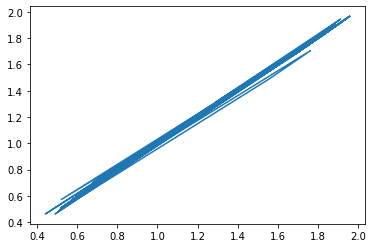

In [ ]:
#graph
Y_pred = model.predict(X_val)
plt.plot(Y_pred,Y_val)
plt.savefig('/content/gdrive/My Drive/hackathon/rnn_result.jpeg')

In [ ]:
for y_pred,y_true in zip(Y_pred,Y_val):
    print(y_pred,y_true)

[0.88862187] 0.8983683
[1.0201362] 1.0292577
[1.1841912] 1.1819619
[1.5373591] 1.5310003
[1.708884] 1.7055193
[1.7901866] 1.792779
[1.8382126] 1.8364087
[1.3350925] 1.3346661
[1.3350925] 1.3346661
[1.4932703] 1.4873705
[1.4029158] 1.4001108
[1.0645066] 1.0728874
[0.6999257] 0.70203424
[1.7635206] 1.7055193
[1.5548077] 1.4873705
[0.5261662] 0.50570023
[0.6402088] 0.6365896
[1.5373591] 1.5310003
[0.544657] 0.5275151
[1.3803358] 1.378296
[1.5816188] 1.57463
[1.5363489] 1.5528151
[1.2908319] 1.3128513
[1.9134648] 1.9454832
[1.853402] 1.8800385
[1.7506552] 1.770964
[0.6784952] 0.70203424
[0.80482435] 0.8329236
[0.6402088] 0.6365896
[0.62069315] 0.61477464
[1.9592378] 1.9672982
[1.6906005] 1.6837045
[1.4704005] 1.4655555
[1.9394487] 1.9454832
[0.6599219] 0.65840447
[1.6473206] 1.6400747
[1.6906005] 1.6837045
[1.7546415] 1.7491492
[0.93223125] 0.94199806
[1.5816188] 1.57463
[0.71925545] 0.7238491
[0.5955266] 0.59295976
[1.6244361] 1.6182598
[1.7120692] 1.7055193
[1.0201362] 1.0292577
[0.78213

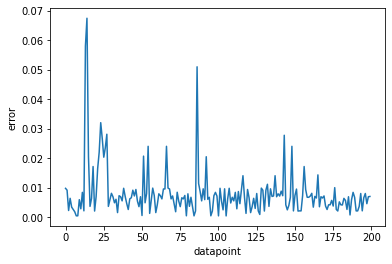

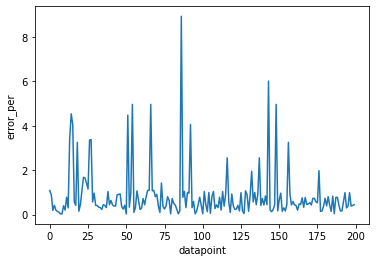

In [ ]:
#errors and error percentage
errors = []
errors_per = []
for y_pred,y_true in zip(Y_pred,Y_val):
    if y_true != 0:
        errors.append(abs(y_pred-y_true))
        errors_per.append((abs(y_pred-y_true)/y_true)*100)
nums = [i for i in range(len(errors))]
#errors plot
plt.plot(nums,errors)
plt.xlabel('datapoint')
plt.ylabel('error')
plt.show()

#errors_percentage plot
plt.plot(nums,errors_per)
plt.xlabel('datapoint')
plt.ylabel('error_per')
plt.show()

In [ ]:
print('max erros : {}'.format(max(errors)))
print('max percentage error : {}'.format(max(errors_per)))

max erros : [0.06743717]
max percentage error : [8.9239645]


In [ ]:
arg_er = np.argmax(errors)
arg_er_per = np.argmax(errors_per)

In [ ]:
errors[165]

array([0.01430666], dtype=float32)

In [ ]:
model = load_model('/content/gdrive/My Drive/hackathon/final_tuned.h5')
#arrays of (5,2) for timeseries prediction
X_test = []
for i in range(test_data.shape[0]):
    #considering 5 at a time
    x = test_data.iloc[i,2:7].values.astype('float32')
    indicies = np.where(x==0)
    mask = np.zeros((5,1))
    mask[indicies]=1
    x = np.concatenate((np.expand_dims(x,axis = -1),mask),axis=-1)
    X_test.append(x)
X_test = np.asarray(X_test)


In [ ]:
X_test.shape

(3331, 5, 2)

In [ ]:
Y_pred = model.predict(X_test)

In [ ]:
#directories
test_dir = '/content/gdrive/My Drive/hackathon/Test_dataset.xlsx'
#loading data
test_data =pd.read_excel(test_dir)

#show top 5 rows of training dataframe
test_data.head()

,Stock Index,Index,Industry,VWAP,General Index,NAV,P/E Ratio,Volumes Traded,Inventory Turnover,Covid Impact (Beta),Tracking Error,Dollar Exchange Rate,Put-Call Ratio,P/B Ratio
0,AC3235,NSE,Materials,53.30,11270.15,44.59,185.09,12067855.0,2.78,0.03,0.0330,74.9,0.80,4.66
1,AC3236,JSE,Energy,749.34,55722.00,74.20,34.01,6172474.0,6.78,0.11,0.0464,17.7,0.86,6.11
2,AC3237,S&P 500,Information Tech,567.75,3351.28,88.41,177.40,17472488.0,4.36,0.23,0.0401,1.0,0.93,4.99
3,AC3238,NSE,Healthcare,646.78,11270.15,79.36,105.44,15553159.0,2.77,0.78,0.0187,74.9,1.09,1.26
4,AC3239,NYSE,Materials,380.33,12765.84,19.90,139.40,12525784.0,5.93,0.03,0.0261,1.0,NaN,6.18


In [ ]:
test_data['Put-Call Ratio'] = Y_pred

In [ ]:
test_data.head()

,Stock Index,Index,Industry,VWAP,General Index,NAV,P/E Ratio,Volumes Traded,Inventory Turnover,Covid Impact (Beta),Tracking Error,Dollar Exchange Rate,Put-Call Ratio,P/B Ratio
0,AC3235,NSE,Materials,53.30,11270.15,44.59,185.09,12067855.0,2.78,0.03,0.0330,74.9,0.913884,4.66
1,AC3236,JSE,Energy,749.34,55722.00,74.20,34.01,6172474.0,6.78,0.11,0.0464,17.7,1.067779,6.11
2,AC3237,S&P 500,Information Tech,567.75,3351.28,88.41,177.40,17472488.0,4.36,0.23,0.0401,1.0,1.272579,4.99
3,AC3238,NSE,Healthcare,646.78,11270.15,79.36,105.44,15553159.0,2.77,0.78,0.0187,74.9,1.666919,1.26
4,AC3239,NYSE,Materials,380.33,12765.84,19.90,139.40,12525784.0,5.93,0.03,0.0261,1.0,1.862782,6.18


In [ ]:
test_data.to_csv('/content/gdrive/My Drive/hackathon/test_data_from_rnn.csv')